# Lecture 6: simulating quantum noise

<center><img src="../../figures/qibo_mascotte/qibo_noise.png" alt="drawing" width="400"/></center>
<center>Qibo the mangoose suffering noise [DALL-E].</center>

## Introduction

In real life scenarios, quantum computers are imperfect and prone to noise. Some of the noise sources can be:
- **decoerence**, which corresponds to the loss of the quantum properties of the system, usually due to some interaction with the external environment;
- **thermal noise**, which affects in particular systems sensitive to temperature;
- **control errors**, due to some imperfections in the laboratory tools (cables, control boards, etc.);
- **cross-talk**, which happens when some operation we apply to a single qubit unintentionally affect the neighbouring qubits;
- **quantum state leakage**, which is the possibility to access some undesired energy level. It can happen for example using superconducting qubits, which are in principle N-levels systems prepared to isolate the first two energy levels.

More in general, a combination of these phenomena can affect a real quantum device, leading to a simple but relevant problem: the expected results are corrupted. 

In `qibo`, we can simulate noisy systems and implement some strategies to take this problem into account, cleaning our results from undesired corruptions. 

In the following:

1. we define a simple problem, consisting in calculating the expected value of a target observable over the final state we obtain executing a quantum circuit;
2. we compute the exact result with noiseless simulation;
3. we add noise to the circuit and compute the noisy result;

#### 1. Problem definition

We consider as an example a simple quantum system of three qubits, on which we aim to apply some rotations and then compute the expectation value of an observable composed of Pauli's.

In [1]:
# if you don't have already qibo, qibojit and qiboedu installed in your computer
# uncomment and execute the following lines 

# !pip install qibo
# !pip install qibojit
# !pip install git+https://github.com/qiboteam/qiboedu

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates, hamiltonians

from qiboedu.scripts import plotscripts

In [3]:
qibo.set_backend("numpy")

[Qibo 0.2.6|INFO|2024-04-04 11:46:00]: Using qibojit (numba) backend on /CPU:0


In [4]:
nqubits = 3
nlayers = 3

# activate density matrix mode
c = Circuit(nqubits, density_matrix=True)
for l in range(nlayers):
    for q in range(nqubits):
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    for q in range(0, nqubits-1, 1):
        c.add(gates.CNOT(q0=q, q1=q+1))
c.add(gates.M(*range(nqubits)))

MeasurementResult(qubits=(0, 1, 2), nshots=0)

In [5]:
c.draw()

q0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
q2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


Now the circuit is set up and we can fix its action by injecting a specific list of rotational angles. 

We get the numbers of contained parameters:

In [6]:
nparams = len(c.get_parameters())

And then we generate a well defined set of angles.

In [13]:
angles = np.linspace(0, 2*np.pi, nparams)
print(angles)

[0.         0.36959914 0.73919827 1.10879741 1.47839654 1.84799568
 2.21759481 2.58719395 2.95679309 3.32639222 3.69599136 4.06559049
 4.43518963 4.80478876 5.1743879  5.54398704 5.91358617 6.28318531]


In [14]:
# set the angles into the circuit
c.set_parameters(angles)

Now we have a quantum circuit composed of rotations and some CNOT gates. We want to use it to compute some calculations. 

To do this, we can define an observable $\mathcal{O}$, for which we calculate:

$$ \langle \mathcal{O} \rangle \equiv \langle 0 | U^{\dagger}\, \mathcal{O}\, U | 0 \rangle \\. $$

We make the choice:

$$ \mathcal{O} = - \sum_{i=0}^N Z_i \\.$$

In [15]:
# observable definition
obs = hamiltonians.Z(nqubits=nqubits)
print(obs.matrix)

[[-3.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  3.-0.j]]


#### 2. Computing the exact expectation value

(0.04098+0j)|000><000| + (0.05215+0.09312j)|000><001| + (-0.00872-0.02801j)|000><010| + (-0.03659-0.10883j)|000><011| + (0.02184-0.00063j)|000><100| + (0.00065+0.0529j)|000><101| + (-0.03929+0.03608j)|000><110| + (-0.00399+0.0879j)|000><111| + (0.05215-0.09312j)|001><000| + (0.27797-0j)|001><001| + (-0.07475-0.01582j)|001><010| + (-0.29388-0.05533j)|001><011| + (0.02635-0.05043j)|001><100| + (0.12105+0.06585j)|001><101| + (0.032+0.1352j)|001><110| + (0.19468+0.12092j)|001><111| + (-0.00872+0.02801j)|010><000| + (-0.07475+0.01582j)|010><001| + (0.021+0j)|010><010| + (0.08218-0.00185j)|010><011| + ...


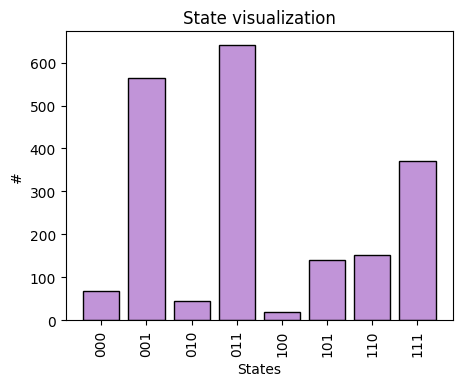

In [16]:
# execute the circuit
final_state = c(nshots=2000)

# print final state
print(final_state)

# collect and visualize frequencies
frequencies = final_state.frequencies(binary=True)
plotscripts.visualize_states(frequencies)

Let's have a look also to the density matrix of this system.
We can use the function `plotscript.plot_density_matrix(state)`, which takes as argument the state object you get from a circuit execution `circuit().state()`. It is important to set the variable `density_matrix=True` when initializing the circuit.

The plot is going to show the absolute value of the amplitudes according to the density matrix 2D notation.

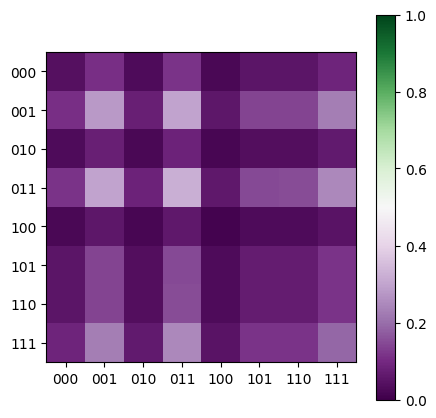

In [19]:
# plot the density matrix using plotscripts.plot_density_matrix(state)
plotscripts.plot_density_matrix(c().state())

As we can see from the plot, we have both diagonal and non diagonal components in the matrix.

The expectation value of this observable, which is diagonal in the computational basis can be computed directly from the frequencies. 

Executing the system, we collect one frequency for each component of the state vector. We call $f_i$ the frequency corresponding to the $i-$th component of the state vector. 

Now, considering an observable $\mathcal{O}$ whose eigenvalues are $\{o_i\}_{i=1}^{2^N}$, the expectation value of $\mathcal{O}$ given the set of frequencies $\{f_i\}_{i=1}^{2^N}$ is:

$$ E[\mathcal{O}] = \frac{1}{2^N} \sum_{i=1}^{2^N} o_i\, f_i. $$

In `Qibo`, this formula is implemented into a method of the `Hamiltonian` object:
`observable.expectation_from_samples(frequencies)`.

In [20]:
# compute the expected value
exp_value = obs.expectation_from_samples(frequencies)

print(exp_value)

0.607


#### 3. Add noise to the system

Various different ways to simulate noise exist in `qibo`, but in this lecture we focus on one of them. 

Let me introduce before the Pauli noise channel, which is used here to corrupt the circuit. If we consider a quantum state represented by the density matrix $\rho$, the effect of a Pauli noise channel on the state is

$$ \mathcal{E}(\rho) = \biggl(1 - \sum_{k=0}p_k\biggr)\rho + \sum_k p_k P_k \,\rho\, P_k \\,
$$

where $P_k$ is the $k$-th Pauli string and $p_k$ is the probability of applying $P_k$. 

This channel allows to formalize a corruption of the state $\rho$ in which each Pauli represents some specific error which can occurr: for example, the Pauli X and Z respectively represent a bit-flip error and a phase-flip error in the qubit state.

We are going to use the `circuit.with_pauli_noise` method, which consists in applying a Pauli noise channel after every gate of the circuit. 

In [26]:
# define the Pauli's probabilities for each qubit of the system
noise_map = {
    0: list(zip(["X", "Z"], [0.007, 0.008])),
    1: list(zip(["Y", "Z"], [0.01, 0.005])),
    2: list(zip(["X", "Z"], [0.008, 0.007]))
}

noisy_c = c.with_pauli_noise(noise_map)

Let's print the new face of the circuit, with the Pauli noise channel after each gate.

In [27]:
noisy_c.draw()

q0: ─RY─PN─RZ─PN─o─PN───RY─PN─RZ─PN────o─PN───RY─PN─RZ─PN────o─PN──────M─
q1: ─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─M─
q2: ─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─M─


In [28]:
# set the parameters

noisy_c.set_parameters(angles)

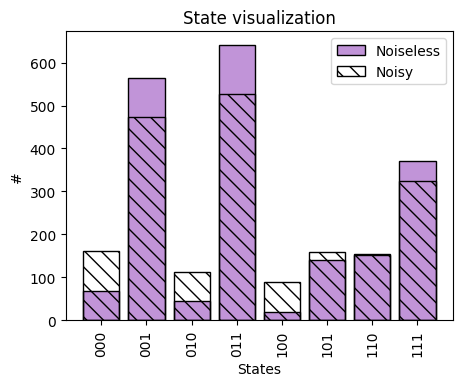

In [29]:
# execute the circuit
noisy_final_state = noisy_c(nshots=2000)

# collect and visualize frequencies
noisy_frequencies = noisy_final_state.frequencies(binary=True)
plotscripts.visualize_states(frequencies, noisy_frequencies)

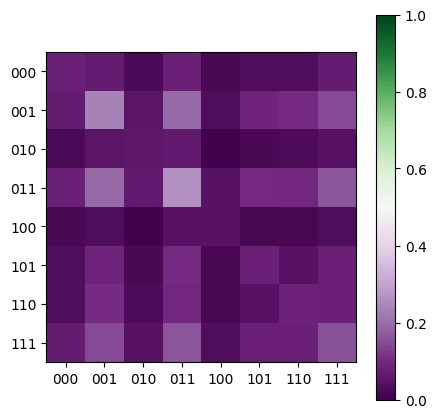

In [30]:
# plot the density matrix using plotscripts.plot_density_matrix(state)
plotscripts.plot_density_matrix(noisy_c().state())

From the matrix, we can see the off diagonal terms are vanishing.

As final step of this lecture 4, let's compute the expectation value of $\mathcal{O}$ over the noisy final state.

In [32]:
noisy_exp = obs.expectation_from_samples(noisy_frequencies)

print(f"Noiseless expectation value: {exp_value}")
print(f"Noisy expectation value: {noisy_exp}")

Noiseless expectation value: 0.607
Noisy expectation value: 0.3290000000000001


<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> what is happening to the system? why is the expected value of $Z$ decreasing? What happens if you increase the magnitude of the noise?
</div>